In [1]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score


In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [3]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = nn.Sequential(CBR(3, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.enc4 = nn.Sequential(CBR(256, 512), CBR(512, 512))
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(CBR(512, 1024), CBR(1024, 1024))
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(CBR(1024, 512), CBR(512, 512))
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(CBR(512, 256), CBR(256, 256))
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 128))
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))
        
        # Output layer
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1, )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.conv_last(dec1)

In [3]:
# Veri hazırlama
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
train_dataset = SegmentationDataset("mitokondri/train/image/", "mitokondri/train/label/", transform=transform)
test_dataset = SegmentationDataset("mitokondri/test/", "mitokondri/test/", transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [6]:
# Model, optimizer ve loss function
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [8]:
epochs = 15
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Modelin tahminini al
        outputs = model(images)

        # Loss hesapla
        loss = criterion(outputs, masks)
        
        # Geriye yayılım ve optimize etme
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}')

Epoch 1/15, Loss: 0.7018817812204361
Epoch 2/15, Loss: 0.6253530383110046
Epoch 3/15, Loss: 0.5796559602022171
Epoch 4/15, Loss: 0.5408308357000351
Epoch 5/15, Loss: 0.5099237412214279
Epoch 6/15, Loss: 0.48087749630212784
Epoch 7/15, Loss: 0.4537590444087982
Epoch 8/15, Loss: 0.43476132303476334
Epoch 9/15, Loss: 0.4137139320373535
Epoch 10/15, Loss: 0.39831430464982986
Epoch 11/15, Loss: 0.3848017677664757
Epoch 12/15, Loss: 0.37203435599803925
Epoch 13/15, Loss: 0.3624406158924103
Epoch 14/15, Loss: 0.35178928822278976
Epoch 15/15, Loss: 0.3434641882777214


In [9]:
# Test sırasında modelin doğrulamasını yapalım
model.eval()  # Modeli değerlendirme moduna al
test_loss = 0
with torch.no_grad():  # Test sırasında geri yayılım (backpropagation) yapılmaz
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Modelin tahminini al
        outputs = model(images)

        # Loss hesapla
        loss = criterion(outputs, masks)
        test_loss += loss.item()

print(f'Test Loss: {test_loss/len(test_loader)}')

Test Loss: 0.8113566488027573


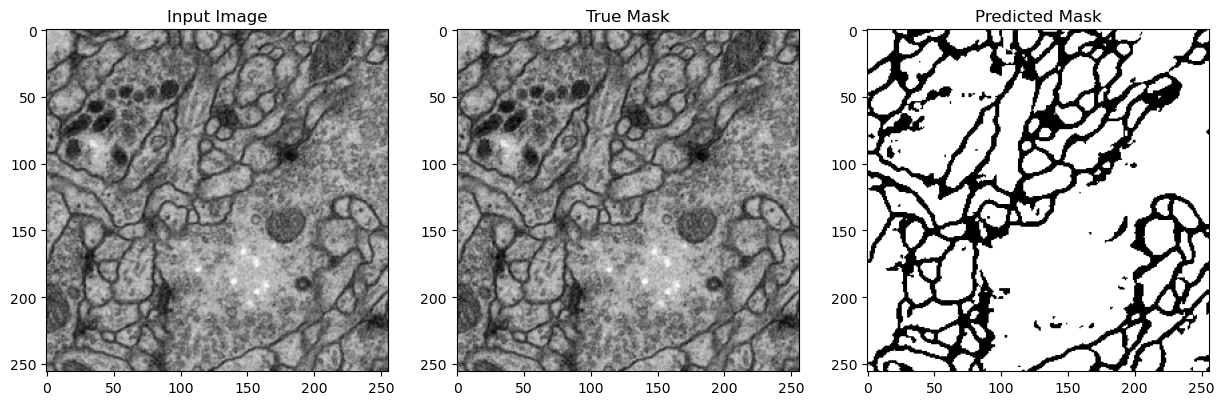

In [10]:
#True maskların elimde olduğu veri setlerinde kullanılacak.

# Test veri setinden rastgele bir örnek seçip görselleştirme
model.eval()  # Modeli değerlendirme moduna al
with torch.no_grad():  # Geriye yayılım yapmayacağımız için no_grad
    images, masks = next(iter(test_loader))  # Test loader'dan bir batch al
    images = images.to(device)
    masks = masks.to(device)

    # Modelin tahminini al
    outputs = model(images)

    # Sadece ilk görüntüyü görselleştirelim
    image = images[0].cpu().permute(1, 2, 0).numpy()  # Görüntüyü HWC formatına çevir
    true_mask = masks[0].cpu().squeeze().numpy()  # Gerçek maskeyi (1, 256, 256) -> (256, 256) yap
    predicted_mask = torch.sigmoid(outputs[0]).cpu().squeeze().numpy()  # Tahmin edilen maskeyi (256, 256) yap
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Tahmin maskesini 0 ve 1'e dönüştür

    # Görüntüleme
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')

    ax[1].imshow(true_mask, cmap='gray')
    ax[1].set_title('True Mask')

    ax[2].imshow(predicted_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')

    plt.show()


In [11]:
def calculate_iou_scikit(true_mask, pred_mask):
    # Maskeleri düzleştirip 1D hale getirelim
    true_mask = true_mask.flatten()
    pred_mask = pred_mask.flatten()
    
    # IoU'yu hesaplayalım (Jaccard Score)
    iou_score = jaccard_score(true_mask, pred_mask, average='binary')
    return iou_score

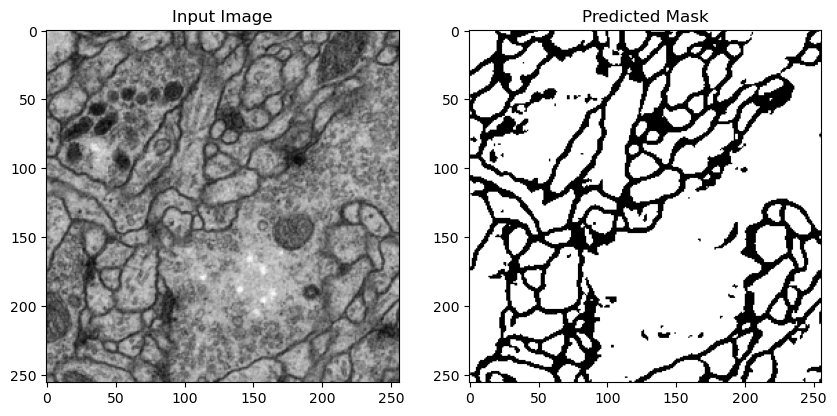

In [12]:
# Test veri setinden rastgele bir örnek seçip görselleştirme
model.eval()  # Modeli değerlendirme moduna al
with torch.no_grad():  # Geriye yayılım yapmayacağımız için no_grad
    images, masks = next(iter(test_loader))  # Test loader'dan bir batch al
    images = images.to(device)
    masks = masks.to(device)

    # Modelin tahminini al
    outputs = model(images)

    # Sadece ilk görüntüyü görselleştirelim
    image = images[0].cpu().permute(1, 2, 0).numpy()  # Görüntüyü HWC formatına çevir

    # # Gerçek maskeyi binary hale getirelim (eger gerekirse)
    # true_mask = masks[0].cpu().squeeze().numpy()
    # true_mask = (true_mask > 0).astype(np.uint8)  # Herhangi bir 0 dışındaki değerleri 1'e dönüştür

    # Tahmin edilen maskeyi sigmoid ile alıp binary yapalım
    predicted_mask = torch.sigmoid(outputs[0]).cpu().squeeze().numpy()
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # 0.5'ten büyük olanları 1 yap

    # IoU'yu scikit-learn ile hesapla
    #iou_score = calculate_iou_scikit(true_mask, predicted_mask)
    
    # Görüntüleme
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')

    # ax[1].imshow(true_mask, cmap='gray')
    # ax[1].set_title('True Mask')

    ax[1].imshow(predicted_mask, cmap='gray')
    ax[1].set_title(f'Predicted Mask')
    # ax[1].imshow(predicted_mask, cmap='gray')
    # ax[1].set_title(f'Predicted Mask\nIoU: {iou_score:.4f}')

    plt.show()


In [14]:
torch.save(model.state_dict(), "unet_weights.pth") # Modelin sadece agırlıklarını kaydet.

## PreTrained U-Net model (smp kütüphanesi ile)

In [6]:
image = train_dataset[0]

In [11]:
# Örneğin, train_loader'ın daha önce tanımlandığını varsayıyoruz
dataiter = iter(train_loader)
images, masks = next(dataiter)

# Görüntülerin ve maskelerin boyutlarını yazdır
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

Images shape: torch.Size([8, 3, 256, 256])
Masks shape: torch.Size([8, 1, 256, 256])


In [15]:
import segmentation_models_pytorch as smp

/home/h4rry/anaconda3/envs/cudaEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
premodel = smp.Unet(
    encoder_name="resnet34",
    #encoder_weights="unet_weights.pth",
    in_channels=3, # RGB için 3
    classes=3 # Sınıf sayısı. Binary segmentation için 1 yapılır.
)

In [17]:
epochs = 15
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Modelin tahminini al
        outputs = model(images)

        # Loss hesapla
        loss = criterion(outputs, masks)
        
        # Geriye yayılım ve optimize etme
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}')

Epoch 1/15, Loss: 0.3349423110485077
Epoch 2/15, Loss: 0.328532911837101
Epoch 3/15, Loss: 0.3215929940342903
Epoch 4/15, Loss: 0.3177483156323433
Epoch 5/15, Loss: 0.3121291771531105
Epoch 6/15, Loss: 0.30714134871959686
Epoch 7/15, Loss: 0.3027418255805969
Epoch 8/15, Loss: 0.29839013516902924
Epoch 9/15, Loss: 0.296888068318367
Epoch 10/15, Loss: 0.29185493290424347
Epoch 11/15, Loss: 0.2890564873814583
Epoch 12/15, Loss: 0.2859513759613037
Epoch 13/15, Loss: 0.2831086367368698
Epoch 14/15, Loss: 0.2805985286831856
Epoch 15/15, Loss: 0.27766314148902893


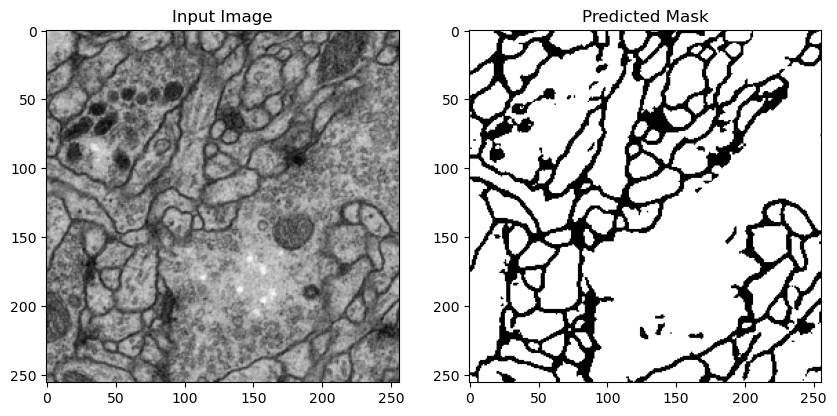

In [19]:
model.eval()
with torch.no_grad():
    images = next(iter(test_loader))[0].to(device)  # Train loader da kullanılabilir
    outputs = model(images)

    # Tahmin edilen maskeyi sigmoid ile alıp binary yapalım
    predicted_mask = torch.sigmoid(outputs[0]).cpu().squeeze().numpy()
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Görüntüleme
    image = images[0].cpu().permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')

    ax[1].imshow(predicted_mask, cmap='gray')
    ax[1].set_title('Predicted Mask')

    plt.show()


In [7]:
from sklearn.metrics import f1_score

def calculate_f1_scikit(true_mask, pred_mask):
    # Tahmin edilen maskeyi binary hale getir (0.5 threshold)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Maskeleri flatten ederek 1D hale getir
    true_mask = true_mask.cpu().numpy().flatten()
    pred_mask = pred_mask.flatten()

    # F1 skoru hesapla
    f1 = f1_score(true_mask, pred_mask, average='binary')
    return f1
